## MNIST 

In [130]:
import os
import torch
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
from matplotlib.pyplot import figure

import matplotlib.pyplot as plt

In [131]:
root = './data'
if not os.path.exists(root):
    os.mkdir(root)

In [132]:
train_set = dset.MNIST(root=root, train=True, transform=transforms.ToTensor(), download=True)
test_set = dset.MNIST(root=root, train=False, transform=transforms.ToTensor(), download=True)

In [133]:
batch_size = 50
total_epoch = 30
learning_rate = 0.05
use_cuda = torch.cuda.is_available() # [Question 1] What is 'torch.cuda.is_available' used for?

In [134]:
train_loader = torch.utils.data.DataLoader(  # [Question 2] What is 'torch.utils.data.DataLoader' used for?
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)


In [135]:
class p1CNN(nn.Module):
    def __init__(self):
        super(p1CNN, self).__init__()
        self.c1 = nn.Conv2d(1, 6, kernel_size=3, padding=1)
        self.c2 = nn.Conv2d(6, 1, kernel_size=3, padding=1)
        self.mp = nn.MaxPool2d(kernel_size=2)
        self.li = nn.Linear(7*7, 10)
    
    def forward(self, x):
        x = self.mp(F.relu(self.c1(x)))
        x = self.mp(F.relu(self.c2(x)))
        x = x.view(-1, 7*7)
        x = self.li(x)
        return x

def weights_init(m):
    classname = m.__class__.__name__
    for p in model.parameters():
        p.data.fill_(1)

        

In [136]:
model = p1CNN()

if use_cuda:
    model = model.cuda()

tmp = p1CNN()
tmp.load_state_dict(model.state_dict())
# model.apply(weights_init)

<All keys matched successfully>

In [137]:
optimizer = optim.SGD(model.parameters(), lr=learning_rate) # [Question 5] What is 'optim.SGD' used for?
criterion = nn.CrossEntropyLoss() # [Question 6] What is 'nn.CrossEntropyLoss' used for?
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)


In [138]:

para_init = model.state_dict()
optim_init = optimizer.state_dict()
torch.save(model.state_dict(), 'model_init.pt')
torch.save(optimizer.state_dict(), 'optim_init.pt')
print(model.state_dict())
print(optim_init)

OrderedDict([('c1.weight', tensor([[[[ 0.0925, -0.0441,  0.0553],
          [-0.1138, -0.2961,  0.0047],
          [ 0.2043, -0.0859, -0.1000]]],


        [[[ 0.2786, -0.2202, -0.1703],
          [ 0.1581, -0.1463,  0.0819],
          [-0.0489,  0.0269,  0.2253]]],


        [[[ 0.0630, -0.2880, -0.3312],
          [ 0.0864,  0.3215, -0.1820],
          [-0.2329,  0.1246, -0.2132]]],


        [[[-0.1638, -0.0027,  0.2143],
          [ 0.1054,  0.2291, -0.0825],
          [-0.0524, -0.0930, -0.1907]]],


        [[[-0.0395, -0.1994,  0.0414],
          [ 0.1200,  0.1663,  0.1609],
          [-0.0673, -0.0838, -0.1943]]],


        [[[ 0.2045,  0.0437, -0.2027],
          [-0.3034, -0.2230, -0.2194],
          [-0.1230,  0.1417,  0.2724]]]], device='cuda:0')), ('c1.bias', tensor([ 0.0712, -0.1130, -0.0558,  0.1180, -0.1398,  0.2255], device='cuda:0')), ('c2.weight', tensor([[[[-0.0188,  0.0184,  0.0924],
          [ 0.0904, -0.0386, -0.0970],
          [-0.1123, -0.0399, -0.1308]],

  

In [139]:
# model.load_state_dict(torch.load('model_init.pt'))
# optimizer.load_state_dict(torch.load('optim_init.pt'))

# model.load_state_dict(para_init)
print(model.state_dict())
lrd_train_loss = []
lrd_test_acc = []
for epoch in range(total_epoch):
    # trainning
    total_loss = 0
    total_batch = 0
    for batch_idx, (x, target) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad() # [Question 7] What is 'optimizer.zero_grad()' used for?
        if use_cuda:
            x, target = x.cuda(), target.cuda()
            
        out = model(x)
        loss = criterion(out, target) # [Question 8] What are 'out' and 'target' and what is output of criterion(out, target)?

        total_loss += loss.item()
        total_batch += 1
        loss.backward() # [Question 9] What is 'loss.backward()' used for?
        optimizer.step() # [Question 10] What is 'optimizer.step()' used for?
    print ('==>>> epoch: {}, batch index: {}, train loss: {:.6f}'
            .format(epoch, batch_idx+1, total_loss / total_batch))
    lrd_train_loss.append(total_loss / total_batch)
    
    # testing
    total_loss = 0
    total_batch = 0
    correct_cnt = 0
    total_cnt = 0
    
    for batch_idx, (x, target) in enumerate(test_loader):
        model.eval()
        if use_cuda:
            x, target = x.cuda(), target.cuda()
            
        out = model(x)
        loss = criterion(out, target)
        _, pred_label = torch.max(out.data, 1)
        total_cnt += x.data.size()[0]
        correct_cnt += (pred_label == target.data).sum().item()
        
        total_loss += loss.item()
        total_batch += 1
        
    print ('==>>> epoch: {}, batch index: {}, test loss: {:.6f}, acc: {:.3f}'
            .format(epoch, batch_idx+1, total_loss / total_batch, correct_cnt * 1.0 / total_cnt))
    lrd_test_acc.append(correct_cnt * 1.0 / total_cnt)
    lr_scheduler.step()
    for param_group in optimizer.param_groups:
        print(param_group['lr'])

    print(batch_size)

OrderedDict([('c1.weight', tensor([[[[ 0.0925, -0.0441,  0.0553],
          [-0.1138, -0.2961,  0.0047],
          [ 0.2043, -0.0859, -0.1000]]],


        [[[ 0.2786, -0.2202, -0.1703],
          [ 0.1581, -0.1463,  0.0819],
          [-0.0489,  0.0269,  0.2253]]],


        [[[ 0.0630, -0.2880, -0.3312],
          [ 0.0864,  0.3215, -0.1820],
          [-0.2329,  0.1246, -0.2132]]],


        [[[-0.1638, -0.0027,  0.2143],
          [ 0.1054,  0.2291, -0.0825],
          [-0.0524, -0.0930, -0.1907]]],


        [[[-0.0395, -0.1994,  0.0414],
          [ 0.1200,  0.1663,  0.1609],
          [-0.0673, -0.0838, -0.1943]]],


        [[[ 0.2045,  0.0437, -0.2027],
          [-0.3034, -0.2230, -0.2194],
          [-0.1230,  0.1417,  0.2724]]]], device='cuda:0')), ('c1.bias', tensor([ 0.0712, -0.1130, -0.0558,  0.1180, -0.1398,  0.2255], device='cuda:0')), ('c2.weight', tensor([[[[-0.0188,  0.0184,  0.0924],
          [ 0.0904, -0.0386, -0.0970],
          [-0.1123, -0.0399, -0.1308]],

  

In [128]:
batch_size = 100
total_epoch = 30
learning_rate = 0.05
use_cuda = torch.cuda.is_available() # [Question 1] What is 'torch.cuda.is_available' used for?

model = p1CNN()

if use_cuda:
    model = model.cuda()
# model.apply(weights_init)
model.load_state_dict(tmp.state_dict())

optimizer = optim.SGD(model.parameters(), lr=learning_rate) # [Question 5] What is 'optim.SGD' used for?
criterion = nn.CrossEntropyLoss() # [Question 6] What is 'nn.CrossEntropyLoss' used for?
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)


para_init = model.state_dict()
optim_init = optimizer.state_dict()
torch.save(model.state_dict(), 'model_init.pt')
torch.save(optimizer.state_dict(), 'optim_init.pt')
print(model.state_dict())
print(optim_init)

# Batch size increasing.

# model.load_state_dict(torch.load('model_init.pt'))
# optimizer.load_state_dict(torch.load('optim_init.pt'))

# model.load_state_dict(para_init)
# optimizer.load_state_dict(optim_init)
print(model.state_dict())
bsi_train_loss = []
bsi_test_acc = []
for epoch in range(total_epoch):
    if epoch < 3:
        batch_size = 50
    elif epoch < 6:
        batch_size = 100
    elif epoch < 9:
        batch_size = 200
    else:
        batch_size = 400
    train_loader = torch.utils.data.DataLoader(  # [Question 2] What is 'torch.utils.data.DataLoader' used for?
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)
    test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)
    # trainning
    total_loss = 0
    total_batch = 0
    for batch_idx, (x, target) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad() # [Question 7] What is 'optimizer.zero_grad()' used for?
        if use_cuda:
            x, target = x.cuda(), target.cuda()
            
        out = model(x)
        loss = criterion(out, target) # [Question 8] What are 'out' and 'target' and what is output of criterion(out, target)?

        total_loss += loss.item()
        total_batch += 1
        loss.backward() # [Question 9] What is 'loss.backward()' used for?
        optimizer.step() # [Question 10] What is 'optimizer.step()' used for?
    print ('==>>> epoch: {}, batch index: {}, train loss: {:.6f}'
            .format(epoch, batch_idx+1, total_loss / total_batch))
    bsi_train_loss.append(total_loss / total_batch)
    
    # testing
    total_loss = 0
    total_batch = 0
    correct_cnt = 0
    total_cnt = 0
    
    for batch_idx, (x, target) in enumerate(test_loader):
        model.eval()
        if use_cuda:
            x, target = x.cuda(), target.cuda()
            
        out = model(x)
        loss = criterion(out, target)
        _, pred_label = torch.max(out.data, 1)
        total_cnt += x.data.size()[0]
        correct_cnt += (pred_label == target.data).sum().item()
        
        total_loss += loss.item()
        total_batch += 1
        
    print ('==>>> epoch: {}, batch index: {}, test loss: {:.6f}, acc: {:.3f}'
            .format(epoch, batch_idx+1, total_loss / total_batch, correct_cnt * 1.0 / total_cnt))
    bsi_test_acc.append(correct_cnt * 1.0 / total_cnt)
    # lr_scheduler.step()
    for param_group in optimizer.param_groups:
        print(param_group['lr'])
    print(batch_size)

-02,  1.1315e-01, -1.4223e-01, -4.4571e-02],
        [ 9.7951e-02, -1.3406e-01, -3.3114e-02,  5.9820e-02,  2.7808e-02,
         -6.8903e-02, -6.0153e-02, -8.8767e-02, -1.0317e-01,  8.6698e-02,
          5.5030e-02, -1.3284e-01,  6.9594e-02,  3.4479e-02,  5.9333e-02,
         -9.6490e-02,  2.7401e-02,  9.5722e-02, -2.3817e-03,  8.7552e-02,
          1.2327e-01,  1.1316e-01,  4.7774e-02,  2.4526e-03, -6.2129e-02,
          5.3357e-02, -8.7845e-02,  7.9004e-02,  2.8070e-02,  8.5615e-02,
          6.6302e-02, -1.0592e-01, -1.2879e-01,  3.4069e-03, -5.5848e-02,
         -1.2851e-01, -1.2990e-01, -3.4027e-02, -5.3044e-02,  8.2646e-02,
          9.6923e-02,  4.2569e-03, -1.2952e-01, -8.5417e-02, -5.0403e-02,
         -6.5623e-02,  1.3446e-01,  9.2206e-02,  9.8122e-02],
        [-1.0480e-01, -4.2144e-02, -1.2213e-01,  1.1575e-01,  6.7105e-02,
          9.2445e-02, -5.4336e-02, -1.2235e-01,  1.3456e-01, -1.1189e-01,
          7.1115e-02, -8.4091e-03,  7.7561e-02,  4.6410e-02,  4.3646e-03,
     

Text(0.5, 1.0, 'Comparison of test acc by \nLR decay and Batch size increasing')

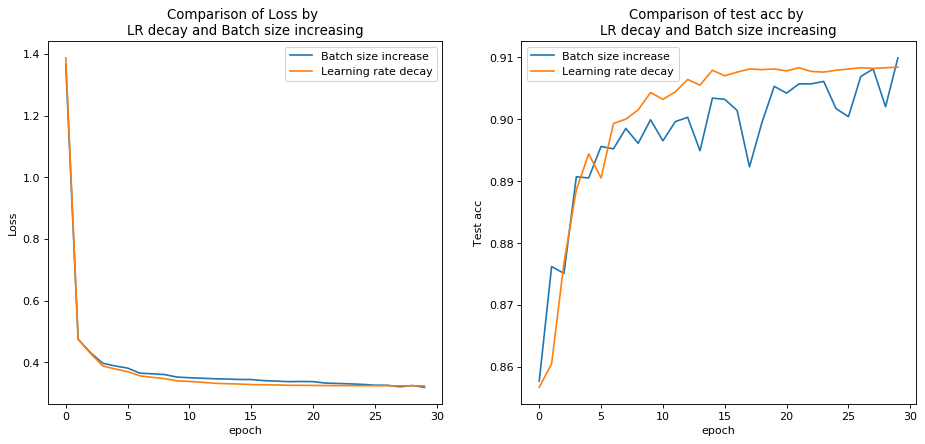

In [129]:
figure(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(121)
line1, = plt.plot(bsi_train_loss)
line2, = plt.plot(lrd_train_loss)
plt.legend(handles=(line1, line2), labels=('Batch size increase', 'Learning rate decay'))
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.title('Comparison of Loss by \nLR decay and Batch size increasing')

plt.subplot(122)
line1, = plt.plot(bsi_test_acc)
line2, = plt.plot(lrd_test_acc)
plt.legend(handles=(line1, line2), labels=('Batch size increase', 'Learning rate decay'))
plt.ylabel('Test acc')
plt.xlabel('epoch')
plt.title('Comparison of test acc by \nLR decay and Batch size increasing')